# Data Analysis

Ashley Feiler, aef56@pitt.edu

New continuing from Compiling Data

## Imports

In [1]:
import pickle
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

Now to unpickle the dataframe I compiled from before, and I'll run through some basic stats just as a reminder.

In [2]:
f = open('/Users/ashleyfeiler/Documents/data_science/Goodreads-Genre-Reviews-Analysis/data/analysis_df.pkl', 'rb')  
df = pickle.load(f)     
f.close()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28274 entries, 0 to 28273
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Text           28274 non-null  object 
 1   Rating         28274 non-null  int64  
 2   Title          28274 non-null  object 
 3   Author         28274 non-null  object 
 4   Category       28274 non-null  object 
 5   Genres         28274 non-null  object 
 6   Language       28274 non-null  object 
 7   Pages          28274 non-null  object 
 8   Pub_Year       28274 non-null  object 
 9   Avg_Rating     28274 non-null  float64
 10  Ratings_Count  28274 non-null  int64  
 11  Toks           28274 non-null  object 
 12  Toks_Lower     28274 non-null  object 
 13  Tok_Count      28274 non-null  int64  
 14  Avg_Word_Len   28118 non-null  float64
 15  Sents          28274 non-null  object 
 16  Sents_Count    28274 non-null  int64  
 17  Avg_Sent_Len   28274 non-null  float64
 18  Nonsen

Looks like the right amount of entries, but 22 columns is a lot, so I'm going to cut these down just a bit and shorten some of the column names. I'm going to remove the 'Genres' column, which lists all the genre tags associated with a book, and rename 'Category' to 'Genre' - sticking with just its original category is good enough for now. I'm also going to eliminate publication year since I don't think that information is necessary, and the Sents columns because I have the original and tokenized text as well as the count and average sentence length, so I don't need to hold onto the sentence-tokenized version.

In [4]:
df = df[['Text', 'Rating', 'Title', 'Author', 'Category', 'Language',
       'Pages', 'Avg_Rating', 'Ratings_Count', 'Toks',
       'Toks_Lower', 'Tok_Count', 'Avg_Word_Len', 'Sents_Count',
       'Avg_Sent_Len', 'Nonsense', 'Sentiment_Num', 'Sentiment_Tag', 'Adjs',
       'Adjs_Count']]
df.columns = ['Text', 'Rating', 'Title', 'Author', 'Genre', 'Lang',
       'Pages', 'Avg_Rating', 'Ratings_Count', 'Toks',
       'Toks_Low', 'Tok_Count', 'Avg_Word_Len', 'Sents_Count',
       'Avg_Sent_Len', 'Nonsense', 'Sentiment_Num', 'Sentiment_Tag', 'Adjs',
       'Adjs_Count']

In [5]:
print(df.shape)
df.head(0)

(28274, 20)


,Text,Rating,Title,Author,Genre,Lang,Pages,Avg_Rating,Ratings_Count,Toks,Toks_Low,Tok_Count,Avg_Word_Len,Sents_Count,Avg_Sent_Len,Nonsense,Sentiment_Num,Sentiment_Tag,Adjs,Adjs_Count


Now all of the columns (19 excluding the index) are visible! Now for all the numerical values, I'm going to compare the descriptive statistics by genre.

In [78]:
df.Genre.value_counts()

ya                        4334
fantasy_paranormal        4323
romance                   3918
mystery_thriller_crime    3789
comics_graphic            3505
history_bio               3362
children                  2858
poetry                    2185
Name: Genre, dtype: int64

Because nonsense text was a small issue when compiling the data, let's take a closer look at the composition of real vs. nonsense text across each genre.

In [100]:
nonsense_df = df.groupby('Genre').Nonsense.value_counts().unstack()

total = nonsense_df.nonsense + nonsense_df.real + nonsense_df.short
nonsense_df['total'] = total

nonsense_percent = nonsense_df.nonsense / nonsense_df.total
nonsense_df['nonsense_percent'] = nonsense_percent

short_percent = nonsense_df.short / nonsense_df.total
nonsense_df['short_percent'] = short_percent

nonsense_df

Nonsense,nonsense,real,short,total,nonsense_percent,short_percent
Genre,,,,,,
children,37,2785,36,2858,0.012946,0.012596
comics_graphic,68,3367,70,3505,0.019401,0.019971
fantasy_paranormal,107,4154,62,4323,0.024751,0.014342
history_bio,60,3267,35,3362,0.017847,0.010410
mystery_thriller_crime,65,3688,36,3789,0.017155,0.009501
poetry,50,2109,26,2185,0.022883,0.011899
romance,101,3739,78,3918,0.025778,0.019908
ya,147,4110,77,4334,0.033918,0.017766


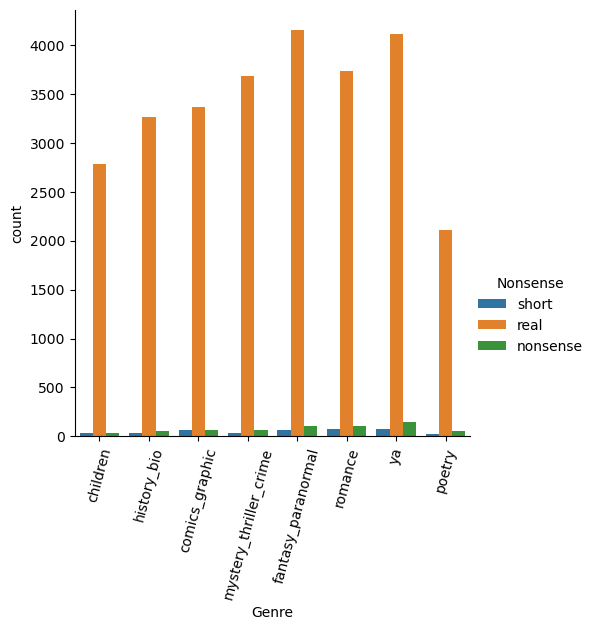

In [101]:
sns.catplot(x='Genre', hue='Nonsense', kind='count', data=df)
plt.xticks(rotation=75)
plt.show()

Luckily, it looks like a fairly even distribution of nonsense and short reviews. The percent of nonsense reviews in a genre ranges only from about 1.3% to 3.4%, which is not a large proportion. Hopefully this won't cause too much of an issue.

## Descriptive Stats by Genre

Lets find out which features are the most distinctive and have the most variation between genres!

In [6]:
df.columns

Index(['Text', 'Rating', 'Title', 'Author', 'Genre', 'Lang', 'Pages',
       'Avg_Rating', 'Ratings_Count', 'Toks', 'Toks_Low', 'Tok_Count',
       'Avg_Word_Len', 'Sents_Count', 'Avg_Sent_Len', 'Nonsense',
       'Sentiment_Num', 'Sentiment_Tag', 'Adjs', 'Adjs_Count'],
      dtype='object')

In [76]:
df.Genre.unique()

array(['children', 'history_bio', 'comics_graphic',
       'mystery_thriller_crime', 'fantasy_paranormal', 'romance', 'ya',
       'poetry'], dtype=object)

In [10]:
#Creates list where I can add all features' ANOVA results to compare significance at once
significance_tests = []

### Rating

In [7]:
df.groupby('Genre').Rating.describe()

,count,mean,std,min,25%,50%,75%,max
Genre,,,,,,,,
children,2858.0,3.904829,1.203209,0.0,3.0,4.0,5.0,5.0
comics_graphic,3505.0,3.811412,1.153754,0.0,3.0,4.0,5.0,5.0
fantasy_paranormal,4323.0,3.816100,1.246819,0.0,3.0,4.0,5.0,5.0
history_bio,3362.0,3.851279,1.215740,0.0,3.0,4.0,5.0,5.0
mystery_thriller_crime,3789.0,3.727105,1.178367,0.0,3.0,4.0,5.0,5.0
poetry,2185.0,3.897941,1.276413,0.0,3.0,4.0,5.0,5.0
romance,3918.0,3.943849,1.212399,0.0,3.0,4.0,5.0,5.0
ya,4334.0,3.781034,1.272587,0.0,3.0,4.0,5.0,5.0


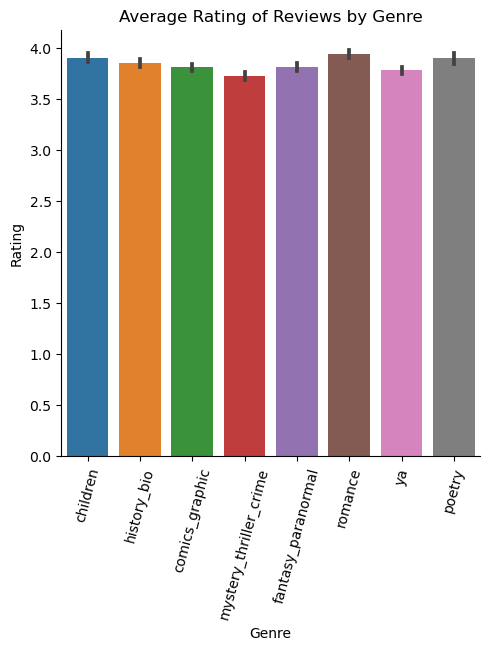

In [77]:
#Using a bar plot because box plot is the same for every genre
sns.catplot(data=df, x='Genre', y='Rating', kind='bar')
plt.title('Average Rating of Reviews by Genre')
plt.xticks(rotation=75)
plt.show()

At first glance there doesn't appear to be a ton of variation. Each genre has the same 1st, 2nd, and 3rd quartile ratings of 3, 4, and 5 stars respectively, and the average doesn't show a ton of variation. However, the chart suggests that mystery/thriller/crime has slightly more negative reviews while romance has slightly more positive reviews, which makes sense given that romance is generally a more positive subject than crime.

In [11]:
#Checks if difference between genres is statistically significant
children_rating = df[(df.Genre == 'children')].Rating
hist_rating = df[(df.Genre == 'history_bio')].Rating
comics_rating = df[(df.Genre == 'comics_graphic')].Rating
mystery_rating = df[(df.Genre == 'mystery_thriller_crime')].Rating
fantasy_rating = df[(df.Genre == 'fantasy_paranormal')].Rating
romance_rating = df[(df.Genre == 'romance')].Rating
ya_rating = df[(df.Genre == 'ya')].Rating                    
poetry_rating = df[(df.Genre == 'poetry')].Rating

rating_test = stats.f_oneway(children_rating, hist_rating, comics_rating, mystery_rating, fantasy_rating, romance_rating, ya_rating, poetry_rating)
print(rating_test)

significance_tests.append(('Rating', rating_test))

F_onewayResult(statistic=12.486821345314613, pvalue=4.471076138185445e-16)


The F-value is about 12.49, meaning the variation in rating between genres is 12x the variation in rating within each genre group and has a significant p-value. This shows that the average rating is different across genres, but 12 isn't a very large F-value, so it's not the most telling feature.

### Average Rating of Book Reviewed

Reminder: Difference between Rating and Avg_Rating
- Rating: the star-value given by a reviewer accompanying their review

- Avg_Rating: the average star-value of the book the review is addressing

In [12]:
df.groupby('Genre').Avg_Rating.describe()

,count,mean,std,min,25%,50%,75%,max
Genre,,,,,,,,
children,2858.0,4.037768,0.263286,2.17,3.89,4.05,4.21,5.00
comics_graphic,3505.0,4.021680,0.327196,2.25,3.84,4.07,4.24,4.83
fantasy_paranormal,4323.0,4.014464,0.299743,2.40,3.82,4.03,4.23,5.00
history_bio,3362.0,3.943968,0.283527,2.42,3.77,3.96,4.14,5.00
mystery_thriller_crime,3789.0,3.884130,0.268984,1.98,3.74,3.90,4.06,4.88
poetry,2185.0,4.096256,0.280143,2.66,3.95,4.12,4.26,5.00
romance,3918.0,4.000403,0.279388,2.50,3.83,4.03,4.20,4.91
ya,4334.0,3.979213,0.280267,2.86,3.80,4.00,4.17,5.00


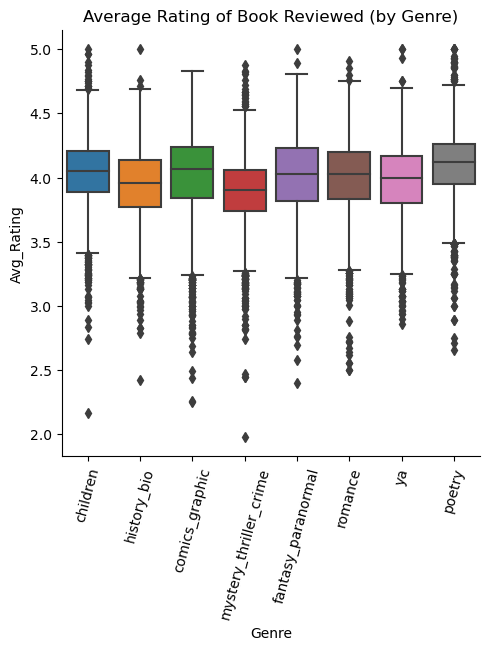

In [80]:
sns.catplot(data=df, x='Genre', y='Avg_Rating', kind='box')
plt.title('Average Rating of Book Reviewed (by Genre)')
plt.xticks(rotation=75)
plt.show()

### Ratings Count

(The number of reviews a book has on Goodreads)

In [14]:
df.groupby('Genre').Ratings_Count.describe()

,count,mean,std,min,25%,50%,75%,max
Genre,,,,,,,,
children,2858.0,93980.546186,275095.225792,1.0,330.0,3001.5,31387.00,1876252.0
comics_graphic,3505.0,16528.807703,41517.096041,1.0,479.0,2705.0,12834.00,406669.0
fantasy_paranormal,4323.0,108879.451076,375846.839796,1.0,838.5,7755.0,55039.00,4765497.0
history_bio,3362.0,96545.556217,342835.065977,0.0,592.0,4165.0,30058.75,3255518.0
mystery_thriller_crime,3789.0,59168.214568,210601.102517,1.0,522.0,3984.0,22034.00,2046499.0
poetry,2185.0,44478.507551,151734.841123,0.0,148.0,1433.0,15270.00,1029527.0
romance,3918.0,32528.685299,143318.963490,1.0,333.0,1878.5,10393.00,2078406.0
ya,4334.0,211864.244347,652314.359248,1.0,2863.5,19151.0,106182.00,4899965.0


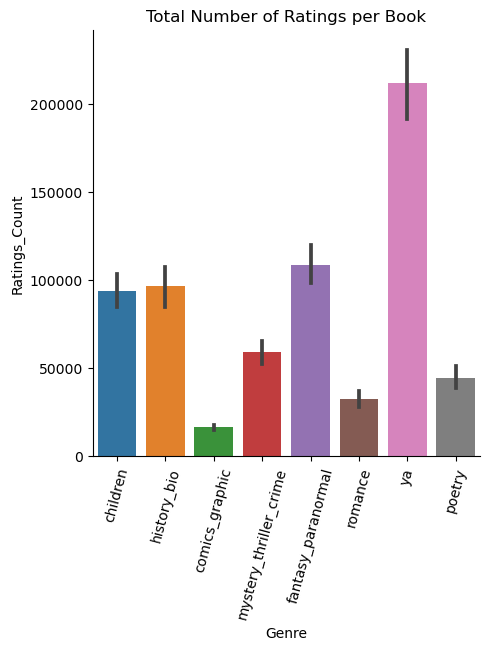

In [81]:
sns.catplot(data=df, x='Genre', y='Ratings_Count', kind='bar')
plt.title('Total Number of Ratings per Book')
plt.xticks(rotation=75)
plt.show()

When compared to the counts of reviews in my dataset for each genre vs. the overall number of reviews shown above, Romance and Children stand out as the most disproportionate. In my dataset, Romance is the 3rd-most reviewed genre with 3918 reviews, whereas romance books had the 7th-most number of reviews out of all 8 genres. On the other hand, Children's Lit is the 7th-most reviewed genre in my dataset with 2858 reviews, but had the 4th-most number of reviews out of all 8 genres. Romance in particular could be a genre to keep an eye on for further analysis - since its books have respectively very few reviews but my dataset has a high frequency of reviews for that genre, it could indicate a very specific and dedicated reader-base made of few but active reviewers, their concentration suggesting more visible linguistic differences in their reviews.

### Token Count

In [16]:
df.groupby('Genre').Tok_Count.describe()

,count,mean,std,min,25%,50%,75%,max
Genre,,,,,,,,
children,2858.0,90.446816,139.108835,1.0,19.0,45.0,101.00,2125.0
comics_graphic,3505.0,106.672183,160.568479,1.0,21.0,52.0,125.00,2877.0
fantasy_paranormal,4323.0,155.552625,216.315288,1.0,29.0,74.0,194.00,3803.0
history_bio,3362.0,147.559786,206.849123,1.0,31.0,75.0,177.00,2566.0
mystery_thriller_crime,3789.0,131.375033,184.020798,1.0,27.0,68.0,163.00,3924.0
poetry,2185.0,117.654005,218.564554,1.0,21.0,53.0,122.00,4159.0
romance,3918.0,161.168453,211.403155,1.0,30.0,80.0,209.75,2110.0
ya,4334.0,163.730964,231.898532,1.0,27.0,74.0,202.75,2840.0


As mentioned in previous notebooks, this data tends to have really large outliers that skew the data (as seen by the difference between the mean and 50% quartile). This makes box plots not very helpful (as shown below). 

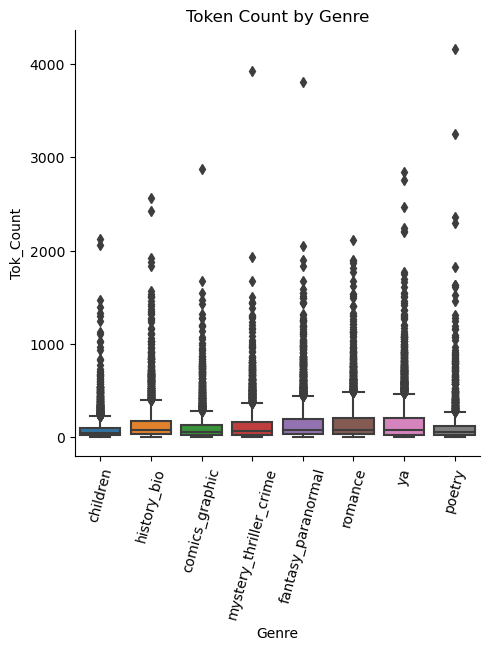

In [82]:
sns.catplot(data=df, x='Genre', y='Tok_Count', kind='box')
plt.title('Token Count by Genre')
plt.xticks(rotation=75)
plt.show()

Therefore, from here on out, I will be using bar charts instead of box plots if the distribution is affected by these same circumstances of outliers. To mitigate the effect of said outliers, I will be using the median as my estimator instead of the mean.

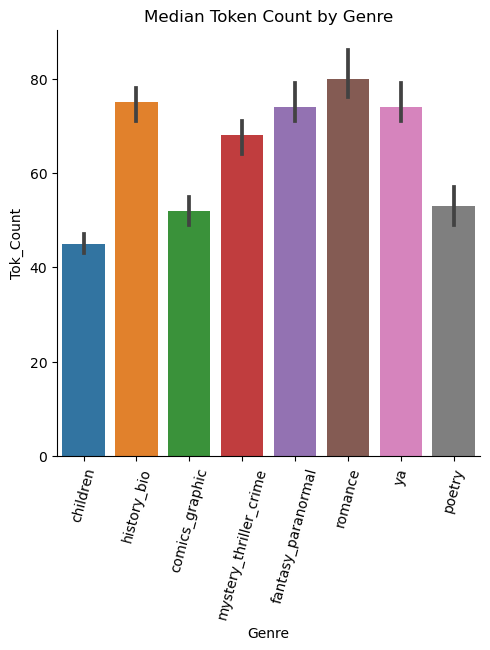

In [83]:
sns.catplot(data=df, x='Genre', y='Tok_Count', kind='bar', estimator=np.median)
plt.title('Median Token Count by Genre')
plt.xticks(rotation=75)
plt.show()

This feature definitely appears to ahve some serious variation. Children's literature, Comics/Graphic Novels, and Poetry generally seem to have the fewest tokens per review. This could be reflective of the text length as all of these genres likely involve shorter texts overall (compared to the other genres, which are most likely novel-length). This could reflect either just less content to discuss, leading to shorter reviews, or the shorter written reviews could reflect these readers' preferences for shorter texts in general.

In [18]:
#Checks if difference between genres is statistically significant

children_toks = df[(df.Genre == 'children')].Tok_Count
hist_tokts = df[(df.Genre == 'history_bio')].Tok_Count
comics_toks = df[(df.Genre == 'comics_graphic')].Tok_Count
mystery_toks = df[(df.Genre == 'mystery_thriller_crime')].Tok_Count
fantasy_toks = df[(df.Genre == 'fantasy_paranormal')].Tok_Count
romance_toks = df[(df.Genre == 'romance')].Tok_Count
ya_toks = df[(df.Genre == 'ya')].Tok_Count                    
poetry_toks = df[(df.Genre == 'poetry')].Tok_Count

toks_test = stats.f_oneway(children_toks, hist_tokts, comics_toks, mystery_toks, fantasy_toks, romance_toks, ya_toks, poetry_toks)
print(toks_test)

significance_tests.append(('Tok_Count', toks_test))

F_onewayResult(statistic=62.70663917469326, pvalue=5.454203218430883e-90)


The F-value is about 62.7, meaning the variation in rating between genres is 62x the variation in rating within each genre group, and it has a significant p-value (almost 0). This shows that the average rating is different across genres, and 62.7 is a much higher F-value, so token count is a distinctive feature across genres.

### Average Word Length

In [19]:
df.groupby('Genre').Avg_Word_Len.describe()

,count,mean,std,min,25%,50%,75%,max
Genre,,,,,,,,
children,2853.0,4.340696,0.730856,1.0,4.000000,4.285714,4.588235,11.5
comics_graphic,3474.0,4.386348,0.734120,1.0,4.036707,4.303751,4.609491,13.0
fantasy_paranormal,4302.0,4.264760,0.676670,1.0,3.968561,4.208661,4.461538,16.0
history_bio,3351.0,4.462218,0.752794,1.0,4.116614,4.382353,4.666667,16.0
mystery_thriller_crime,3774.0,4.365714,0.710656,1.0,4.035714,4.287096,4.585641,14.0
poetry,2174.0,4.451231,0.827943,1.0,4.048611,4.344400,4.684475,13.0
romance,3891.0,4.207006,0.613127,1.0,3.941284,4.160714,4.389480,16.0
ya,4299.0,4.234958,0.687662,1.0,3.947317,4.171334,4.428571,15.0


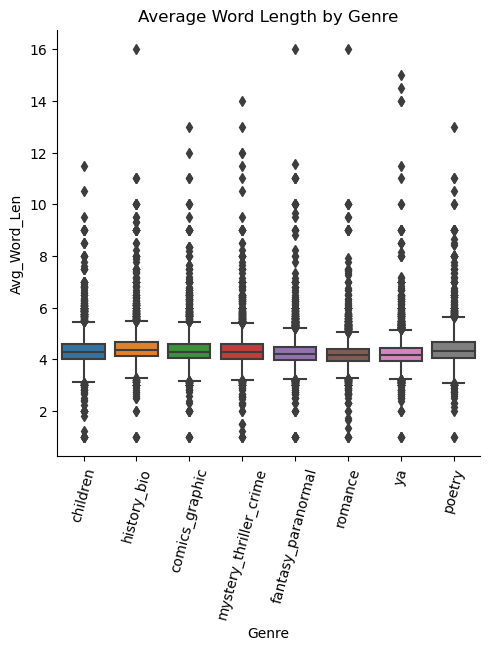

In [85]:
sns.catplot(data=df, x='Genre', y='Avg_Word_Len', kind='box')
plt.title('Average Word Length by Genre')
plt.xticks(rotation=75)
plt.show()

In [21]:
#Checks if difference between genres is statistically significant

children_words = df[(df.Genre == 'children')].Avg_Word_Len
hist_words = df[(df.Genre == 'history_bio')].Avg_Word_Len
comics_words = df[(df.Genre == 'comics_graphic')].Avg_Word_Len
mystery_words = df[(df.Genre == 'mystery_thriller_crime')].Avg_Word_Len
fantasy_words = df[(df.Genre == 'fantasy_paranormal')].Avg_Word_Len
romance_words = df[(df.Genre == 'romance')].Avg_Word_Len
ya_words = df[(df.Genre == 'ya')].Avg_Word_Len                    
poetry_words = df[(df.Genre == 'poetry')].Avg_Word_Len

wordlen_test = stats.f_oneway(children_words, hist_words, comics_words, mystery_words, fantasy_words, romance_words, ya_words, poetry_words)
print(wordlen_test)

significance_tests.append(('Avg_Word_Len', wordlen_test))

F_onewayResult(statistic=nan, pvalue=nan)


I've triple checked this information so I'm not sure why it's coming up as NaN, so I'll have to keep looking at this to see if there's anything to fix. However, just from looking at the graph, there doesn't seem to be a ton of variation, so it's likely not going to be that significant of a feature.

That being said, there is a bit to see when looking at the numerical values of the average word length (and I'm looking at average because the min and max word lengths don't differ dramatically across genres, so if there are outliers, all genres are likely affected similarly). Reviews of History/Biography and Poetry books have the highest average word lengths (4.46 and 4.45 respectively). On the other hand, Romance and YA books have the lowest average word lenghts (4.21 and 4.23 respectively). Word length can be an indicator of vocabulary size as more advanced vocabulary is often longer in length. This could indicate a trend toward the vocabular size of the readers of these genres, with readers of History/Biography and Poetry having a slightly more advanced vocabulary than readers of Romance/YA. However, given the small difference between the two groups and the lack of a statistical test, this is not a well-supported claim and would need more investigation.

### Average Number of Sentences

In [22]:
df.groupby('Genre').Sents_Count.describe()

,count,mean,std,min,25%,50%,75%,max
Genre,,,,,,,,
children,2858.0,5.051784,6.312488,1.0,2.0,3.0,6.0,109.0
comics_graphic,3505.0,5.674750,7.257126,1.0,2.0,3.0,7.0,166.0
fantasy_paranormal,4323.0,8.613232,11.204685,1.0,2.0,5.0,10.0,179.0
history_bio,3362.0,7.389054,9.141050,1.0,2.0,4.0,9.0,89.0
mystery_thriller_crime,3789.0,7.115862,9.080802,1.0,2.0,4.0,9.0,174.0
poetry,2185.0,6.077346,10.417738,1.0,2.0,3.0,6.0,196.0
romance,3918.0,9.147269,11.045130,1.0,2.0,5.0,11.0,129.0
ya,4334.0,9.293263,12.855068,1.0,2.0,5.0,11.0,210.0


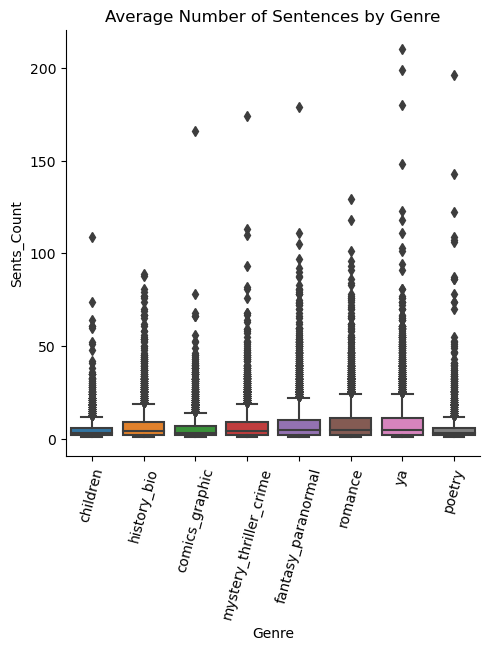

In [88]:
sns.catplot(data=df, x='Genre', y='Sents_Count', kind='box')
plt.title('Average Number of Sentences by Genre')
plt.xticks(rotation=75)
plt.show()

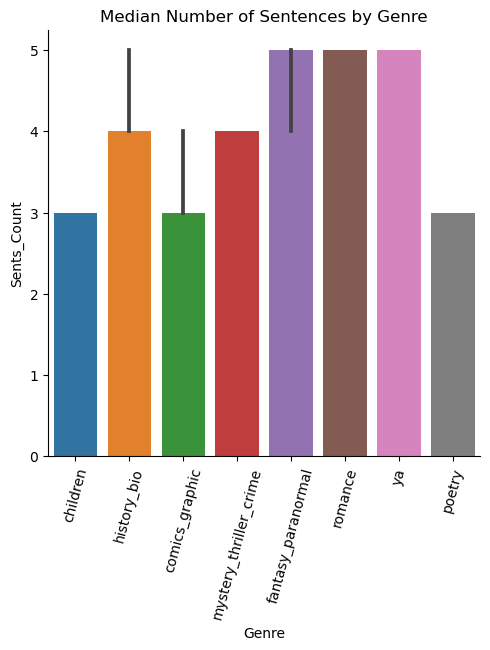

In [89]:
sns.catplot(data=df, x='Genre', y='Sents_Count', kind='bar', estimator=np.median)
plt.title('Median Number of Sentences by Genre')
plt.xticks(rotation=75)
plt.show()

Similarly to token count, Children's Lit, Comics/Graphic Novels, and Poetry have the fewest number of sentences per review

In [25]:
#Checks if difference between genres is statistically significant

children_sents = df[(df.Genre == 'children')].Sents_Count
hist_sents = df[(df.Genre == 'history_bio')].Sents_Count
comics_sents = df[(df.Genre == 'comics_graphic')].Sents_Count
mystery_sents = df[(df.Genre == 'mystery_thriller_crime')].Sents_Count
fantasy_sents = df[(df.Genre == 'fantasy_paranormal')].Sents_Count
romance_sents = df[(df.Genre == 'romance')].Sents_Count
ya_sents = df[(df.Genre == 'ya')].Sents_Count                    
poetry_sents = df[(df.Genre == 'poetry')].Sents_Count

sents_test = stats.f_oneway(children_sents, hist_sents, comics_sents, mystery_sents, fantasy_sents, romance_sents, ya_sents, poetry_sents)
print(sents_test)

significance_tests.append(('Sents_Count', sents_test))

F_onewayResult(statistic=89.83089407728102, pvalue=4.4958483393898035e-130)


The F-value is surprisingly high at about 89.93, meaning the variation in rating between genres is almost 90x the variation in rating within each genre group, and it has a significant p-value (almost 0). This shows that the number of sentences per review is different across genres, and that this is a fairly distinctive feature.

### Average Sentence Length

In [26]:
df.groupby('Genre').Avg_Sent_Len.describe()

,count,mean,std,min,25%,50%,75%,max
Genre,,,,,,,,
children,2858.0,15.537847,9.062199,1.0,10.000000,15.000000,19.770833,262.0
comics_graphic,3505.0,16.377889,9.950796,1.0,10.000000,15.666667,21.200000,258.0
fantasy_paranormal,4323.0,16.622772,11.694261,1.0,11.000000,15.666667,20.600000,388.0
history_bio,3362.0,18.155799,11.226322,1.0,12.333333,17.333333,22.500000,267.0
mystery_thriller_crime,3789.0,16.674117,8.788095,1.0,11.250000,15.900000,21.000000,150.0
poetry,2185.0,17.418711,11.402050,1.0,10.666667,16.000000,21.986486,173.0
romance,3918.0,16.011992,9.643031,1.0,10.500000,15.162281,20.000000,195.0
ya,4334.0,16.034264,9.668900,1.0,10.200000,15.170290,20.000000,205.0


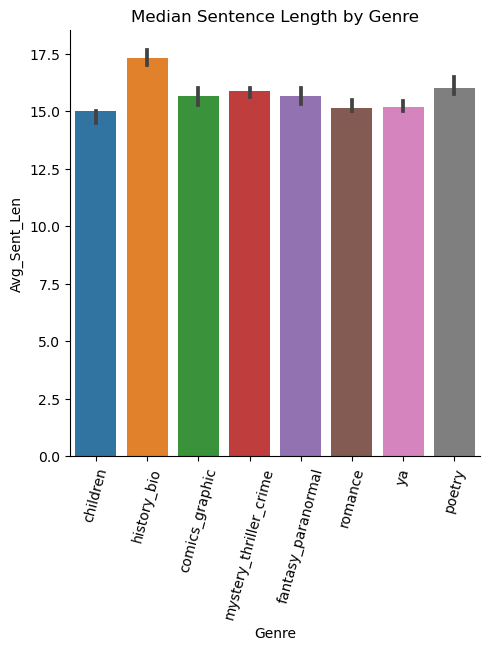

In [90]:
sns.catplot(data=df, x='Genre', y='Avg_Sent_Len', kind='bar', estimator=np.median)
plt.title('Median Sentence Length by Genre')
plt.xticks(rotation=75)
plt.show()

There appears to be some decent variation in sentence length between reviews of different genres, which can be considered an indicator of syntactic complexity (longer sentences usually have more clauses/more complex syntax). The chart indicates that reviews of History/Biography books have the longest sentences, which is interesting because that is the only real nonfiction genre represented (with the possibility of Mystery/Thriller/Crime also including some nonfiction). This could indicate readers of nonfiction books use more syntactically complex sentences. On the other hand, Children's Lit, Romance, and YA books have shorter sentences in their reviews. Children and YA novels are intended for younger audiences, which could explain less syntactic complexity if the reviewers themselves are younger with less-developed language skills. However, the median sentence length across all genres only ranges from about 15-17 tokens, so any differences are likely not too significant.

In [28]:
#Checks if difference between genres is statistically significant

children_sents_len = df[(df.Genre == 'children')].Avg_Sent_Len
hist_sents_len = df[(df.Genre == 'history_bio')].Avg_Sent_Len
comics_sents_len = df[(df.Genre == 'comics_graphic')].Avg_Sent_Len
mystery_sents_len = df[(df.Genre == 'mystery_thriller_crime')].Avg_Sent_Len
fantasy_sents_len = df[(df.Genre == 'fantasy_paranormal')].Avg_Sent_Len
romance_sents_len = df[(df.Genre == 'romance')].Avg_Sent_Len
ya_sents_len = df[(df.Genre == 'ya')].Avg_Sent_Len                    
poetry_sents_len = df[(df.Genre == 'poetry')].Avg_Sent_Len

sentlen_test = stats.f_oneway(children_sents_len, hist_sents_len, comics_sents_len, mystery_sents_len, fantasy_sents_len, romance_sents_len, ya_sents_len, poetry_sents_len)
print(sentlen_test)

significance_tests.append(('Avg_Sent_Len', sentlen_test))


F_onewayResult(statistic=21.570377954827823, pvalue=3.031378324654984e-29)


The F-value is about 21.57, meaning the variation in rating between genres is about 22x the variation in rating within each genre group, and it has a significant p-value. This shows that the median sentence length is different across genres, but it's not the most significant feature.

In [31]:
df.groupby('Genre').Sentiment_Num.describe()

,count,mean,std,min,25%,50%,75%,max
Genre,,,,,,,,
children,2858.0,0.312205,0.269940,-0.7268,0.126007,0.322476,0.507945,0.9784
comics_graphic,3505.0,0.234623,0.290222,-0.8951,0.006133,0.235900,0.439575,0.9780
fantasy_paranormal,4323.0,0.230441,0.258301,-0.8786,0.045948,0.222129,0.400613,0.9796
history_bio,3362.0,0.228653,0.277431,-0.9371,0.036689,0.221982,0.408325,0.9669
mystery_thriller_crime,3789.0,0.178113,0.280476,-0.9493,0.000000,0.165780,0.354567,0.9776
poetry,2185.0,0.242418,0.284537,-0.9078,0.025800,0.242675,0.426777,0.9827
romance,3918.0,0.260603,0.255257,-0.8074,0.087634,0.253128,0.430965,0.9801
ya,4334.0,0.216405,0.259816,-0.8897,0.025913,0.205384,0.376661,0.9903


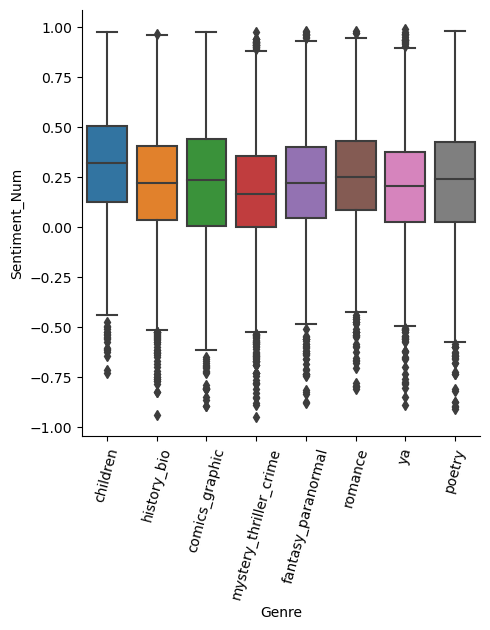

In [32]:
sns.catplot(x='Genre', y='Sentiment_Num', kind='box', data=df)
plt.xticks(rotation=75)
plt.show()

In [33]:
#Checks if difference between genres is statistically significant

children_pos_num = df[(df.Genre == 'children')].Sentiment_Num
hist_pos_num = df[(df.Genre == 'history_bio')].Sentiment_Num
comics_pos_num = df[(df.Genre == 'comics_graphic')].Sentiment_Num
mystery_pos_num = df[(df.Genre == 'mystery_thriller_crime')].Sentiment_Num
fantasy_pos_num = df[(df.Genre == 'fantasy_paranormal')].Sentiment_Num
romance_pos_num = df[(df.Genre == 'romance')].Sentiment_Num
ya_pos_num = df[(df.Genre == 'ya')].Sentiment_Num                    
poetry_pos_num = df[(df.Genre == 'poetry')].Sentiment_Num

posnum_test = stats.f_oneway(children_pos_num, hist_pos_num, comics_pos_num, mystery_pos_num, fantasy_pos_num, romance_pos_num, ya_pos_num, poetry_pos_num)
print(posnum_test)

significance_tests.append(('Sentiment_Num', posnum_test))

F_onewayResult(statistic=65.66681131812767, pvalue=2.2733011670047155e-94)


In [34]:
df.groupby('Genre').Sentiment_Tag.value_counts().unstack()

Sentiment_Tag,negative,neutral,positive
Genre,,,
children,282,174,2402
comics_graphic,572,291,2642
fantasy_paranormal,594,294,3435
history_bio,552,173,2637
mystery_thriller_crime,831,207,2751
poetry,293,210,1682
romance,425,239,3254
ya,640,313,3381


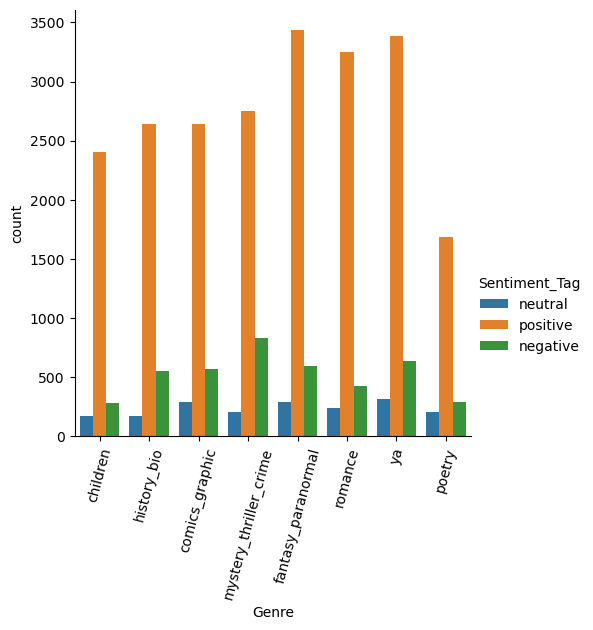

In [35]:
sns.catplot(x='Genre', hue='Sentiment_Tag', kind='count', data=df)
plt.xticks(rotation=75)
plt.show()

In [36]:
df.groupby('Genre').Adjs_Count.describe()

,count,mean,std,min,25%,50%,75%,max
Genre,,,,,,,,
children,2858.0,6.694192,9.726119,0.0,1.0,4.0,8.0,114.0
comics_graphic,3505.0,8.433381,12.010064,0.0,2.0,5.0,10.0,178.0
fantasy_paranormal,4323.0,11.131853,15.379142,0.0,2.0,6.0,14.0,290.0
history_bio,3362.0,10.786139,15.317713,0.0,2.0,6.0,13.0,211.0
mystery_thriller_crime,3789.0,9.256268,12.243096,0.0,2.0,5.0,12.0,204.0
poetry,2185.0,8.412357,14.360697,0.0,1.0,4.0,9.0,254.0
romance,3918.0,10.979326,14.161288,0.0,2.0,6.0,14.0,152.0
ya,4334.0,11.438856,16.253241,0.0,2.0,6.0,14.0,189.0


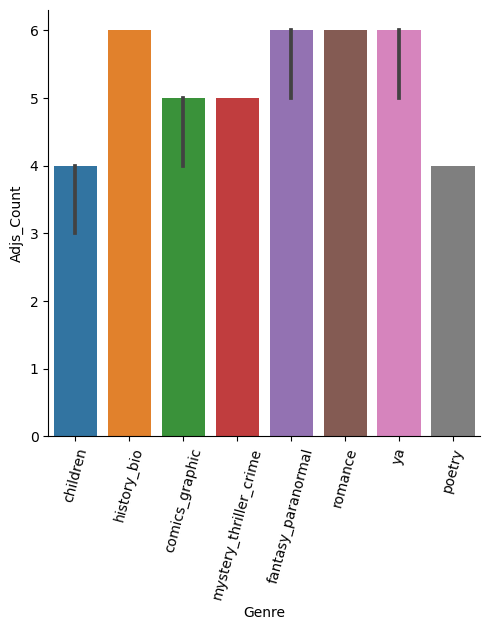

In [37]:
sns.catplot(x='Genre', y='Adjs_Count', kind='bar', estimator=np.median, data=df)
plt.xticks(rotation=75)
plt.show()

In [38]:
#Checks if difference between genres is statistically significant

children_adjs = df[(df.Genre == 'children')].Adjs_Count
hist_adjs = df[(df.Genre == 'history_bio')].Adjs_Count
comics_adjs = df[(df.Genre == 'comics_graphic')].Adjs_Count
mystery_adjs = df[(df.Genre == 'mystery_thriller_crime')].Adjs_Count
fantasy_adjs = df[(df.Genre == 'fantasy_paranormal')].Adjs_Count
romance_adjs = df[(df.Genre == 'romance')].Adjs_Count
ya_adjs = df[(df.Genre == 'ya')].Adjs_Count                    
poetry_adjs = df[(df.Genre == 'poetry')].Adjs_Count

adjs_test = stats.f_oneway(children_adjs, hist_adjs, comics_adjs, mystery_adjs, fantasy_adjs, romance_adjs, ya_adjs, poetry_adjs)
print(adjs_test)

significance_tests.append(('Adjs_Count', adjs_test))

F_onewayResult(statistic=49.115488419623034, pvalue=7.13367352726981e-70)


In [45]:
for (feature, stats) in significance_tests:
    print(feature + ":\n" + str(stats) + "\n")

Rating:
F_onewayResult(statistic=12.486821345314613, pvalue=4.471076138185445e-16)

Tok_Count:
F_onewayResult(statistic=62.70663917469326, pvalue=5.454203218430883e-90)

Avg_Word_Len:
F_onewayResult(statistic=nan, pvalue=nan)

Sents_Count:
F_onewayResult(statistic=89.83089407728102, pvalue=4.4958483393898035e-130)

Avg_Sent_Len:
F_onewayResult(statistic=21.570377954827823, pvalue=3.031378324654984e-29)

Sentiment_Num:
F_onewayResult(statistic=65.66681131812767, pvalue=2.2733011670047155e-94)

Adjs_Count:
F_onewayResult(statistic=49.115488419623034, pvalue=7.13367352726981e-70)



## Machine Learning

### Naive Bayes Classifier (Categorical) 

### Clustering

Code adapted from Na-Rae Han tutorial found [here](https://github.com/Data-Science-for-Linguists-2023/Class-Exercise-Repo/blob/main/activity7_crc/clustering.ipynb)

In [67]:
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_model = TfidfVectorizer(max_features=10000, min_df=2, max_df=0.5, stop_words='english')

x = df['Text']
y = df['Genre']

x_tfidf = tfidf_model.fit_transform(x, y)

In [68]:
from sklearn.decomposition import TruncatedSVD

svd_model = TruncatedSVD(n_components=8)         
x_svd = svd_model.fit_transform(x_tfidf,y)

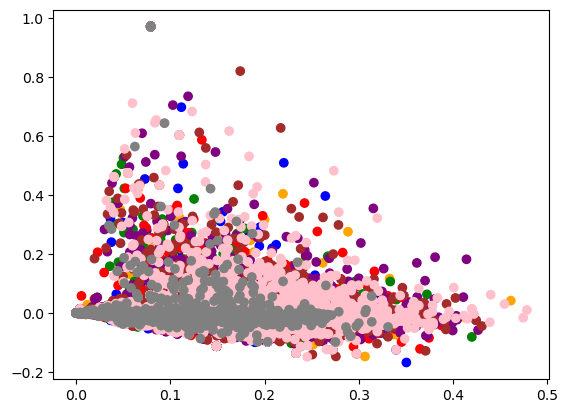

In [69]:
cdict = {'children':'blue', 'history_bio':'orange', 'comics_graphic':'green', 'mystery_thriller_crime':'red',
        'fantasy_paranormal':'purple', 'romance':'brown', 'ya':'pink', 'poetry':'gray'}
colors = y.map(cdict)

plt.scatter(x_svd[:, 0], x_svd[:, 1], c=colors)  
plt.show()

In [75]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF

# custom function for print out topics
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]]))

documents = df.Text
num_feats = 1000
num_tops = 8

tfidf_vect = TfidfVectorizer(max_df=0.95, min_df=2, max_features=num_feats, stop_words='english')
tfidf_docs = tfidf_vect.fit_transform(documents)

nmf_model = NMF(n_components=num_tops, random_state=1, alpha=.1, l1_ratio=.5, 
                init='nndsvd').fit(tfidf_docs)

display_topics(nmf_model, tfidf_vect.get_feature_names(), 10)

/Users/ashleyfeiler/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


Topic 0:
story like just really characters didn time way don know
Topic 1:
book reading great enjoyed amazing wait recommend second review written
Topic 2:
love books heart story romance fall beautiful absolutely just poems
Topic 3:
read great books fun ve quick easy wait best time
Topic 4:
loved wait absolutely story characters amazing great ending beautiful heart
Topic 5:
stars review rating come actual gave half giving liked given
Topic 6:
series books favorite wait characters great far best new reading
Topic 7:
good pretty really ending story bad liked mystery stuff bit


/Users/ashleyfeiler/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Summary

In [47]:
df_test = df.head()

In [48]:
df_test.Adjs.value_counts()

[]                                                                                                                                                  2
[(next, JJ)]                                                                                                                                        1
[(main, JJ)]                                                                                                                                        1
[(luminous, JJ), (more, JJR), (mundane, JJ), (trite, JJ), (poetic, JJ), (back, JJ), (useful, JJ), (informative, JJ), (full, JJ), (unlikely, JJ)]    1
Name: Adjs, dtype: int64

In [57]:
def extract_adjs(adj_list):
    new_adj_list = []
    for (adj, code) in adj_list:
        new_adj_list.append(adj)
    return new_adj_list

In [58]:
df_test['Adjs'] = df_test.Adjs.map(extract_adjs)

/var/folders/j9/9lmff3zj6bxgfpsb8gm8pjrw0000gn/T/ipykernel_36463/760216279.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Adjs'] = df_test.Adjs.map(extract_adjs)


In [60]:
df_test.Adjs

0                                                   []
1                                                   []
2                                               [next]
3                                               [main]
4    [luminous, more, mundane, trite, poetic, back,...
Name: Adjs, dtype: object

In [61]:
df['Adjs'] = df.Adjs.map(extract_adjs)